In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
def filter_df(df, **kwargs):
    for k, v in kwargs.items():
        df = df[df[k] == v]
    return df

In [3]:
r_base = readers.CollectionReader('../src/gaussian_vs_beta/agents')

100%|██████████| 320/320 [00:15<00:00, 20.91it/s]


In [4]:
r_all = readers.CollectionReader('../src/penalty_outside/agents')

100%|██████████| 80/80 [00:04<00:00, 19.25it/s]


In [5]:
games = ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
         "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2","InvertedDoublePendulum-v2"]
code_level_opts = {
      'clip_eps': [0.1, 0.2, 0.3, 1e8],
      'kl_penalty_coeff': [0.0, 0.1, 1.0, 3.0],
      'strict_action_bounds': [True],
      'norm_rewards': ['returns'],
      'policy_net_type': ['CtsPolicy'],
      "adjust_init_std": [False, True],
      'policy_net_type': ['CtsPolicy', 'CtsBetaPolicy'],
      'norm_rewards': ['returns'],
      'norm_advantages': [True, False],
}

In [6]:
opt = pd.concat([r_all.df('optimization'), r_base.df('optimization')])
metadata = pd.concat([r_all.df('metadata'), r_base.df('metadata')])
opt['opt_step'] = opt.index
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
opt = opt.merge(key_metadata, on='exp_id')

In [7]:
# The base exps do not have strict action bounds and adjust init std flags
opt = opt.replace(np.nan, False)

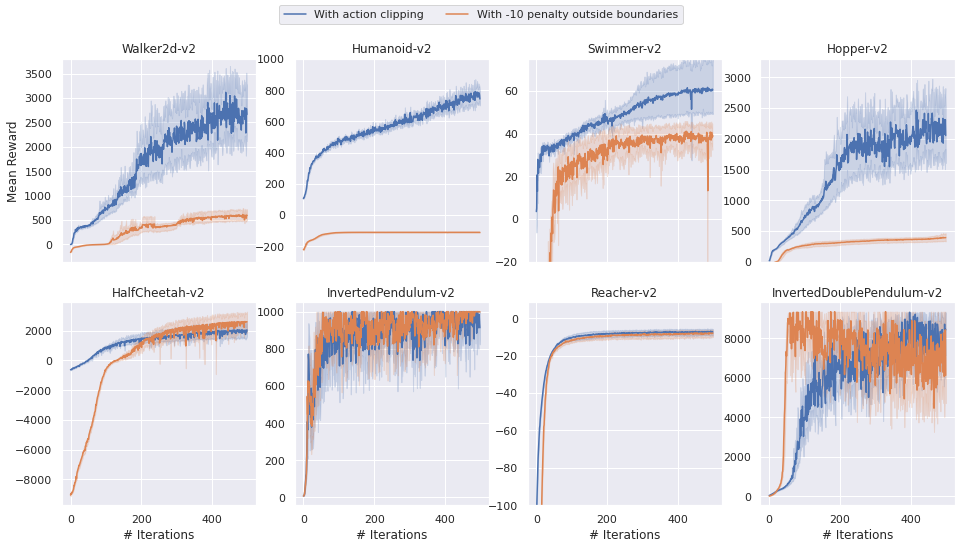

In [8]:
# Plot setup
# CLIP, no adjust std
fig, ax = plt.subplots(2, 4, figsize=(16,8), sharex=True)
ax = ax.flatten()

for j, g in enumerate(games):
    filt = filter_df(opt, game=g, clip_eps=0.2, kl_penalty_coeff=0.0, norm_rewards='returns',
                     strict_action_bounds=False, adjust_init_std=False,
                     policy_net_type='CtsPolicy', norm_advantages=True)
    sns.lineplot(filt.opt_step, filt.mean_reward, n_boot=1000,
                 ax=ax.flatten()[j], label=f"With action clipping", legend=False)
    filt = filter_df(opt, game=g, clip_eps=0.2, kl_penalty_coeff=0.0, norm_rewards='returns',
                     strict_action_bounds=True, adjust_init_std=False, policy_net_type='CtsPolicy',
                     norm_advantages=True)
    sns.lineplot(filt.opt_step, filt.mean_reward, n_boot=1000,
                 ax=ax.flatten()[j], label=f"With -10 penalty outside boundaries", legend=False)
    ax[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_ylabel('Mean Reward')
for a in ax:
    a.set_xlabel('# Iterations')
ax[0].set_ylim([None, 3800])
ax[1].set_ylim([-300, 1000])
ax[2].set_ylim([-20, 75])
ax[3].set_ylim([0, 3300])
ax[6].set_ylim([-100, None])
fig.subplots_adjust(top=0.9)
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
    
plt.show()